# Plotting Climate Data : Subsetting a region

+ **Using ESRI shapefiles to extract climate data for specific regions.**

+ **Plotting the extracted climate data using the proplot package on a map projection.**

## Import all the required packages

In [1]:
import rioxarray as rio
import numpy as np
import xarray as xr
import proplot as plot
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Customize the Proplot package (optional)

In [2]:
plot.rc.reset()

# Font properties (self-explanatory)
plot.rc['font.weight']='bold'
plot.rc['font.size']=14

# Tick propreties (self-explanatory)
plot.rc['tick.labelsize']=14
plot.rc['xtick.minor.visible'] =   False
plot.rc['ytick.minor.visible']=   False
plot.rc['tick.len']=2
plot.rc['tick.dir']= 'out'
plot.rc['xtick.major.size']=3
plot.rc['ytick.major.size']=3

# Grid properties (self-explanatory)
plot.rc['grid']=False
plot.rc['grid.linewidth']=0.25
plot.rc['grid.linestyle']=(0, (5, 10))

# Misc
plot.rc['meta.width']=1.5 # Line width in the plots
plot.rc['subplots.tight']= True # Tight layout for the subplots
plot.rc['colorbar.insetpad']='0.5em' # Insert whitespace around the colorbar
plot.rc['label.size'] = 'medium'


## Using xarray to load the climate data
  
For this example, we will be using the Gridded Rainfall Data from [Indian Meteorological Department (IMD)](https://www.imdpune.gov.in/Clim_Pred_LRF_New/Grided_Data_Download.html) which is available as a netCDF (.nc ) file. NetCDF is the most commonly used file format to store gridded climate data which is also CF compliant. Download the .nc files from the given link : [Rainfall Data](https://www.imdpune.gov.in/Clim_Pred_LRF_New/Grided_Data_Download.html). 
  
+ **After you've downloaded the multiple .nc files, put them all in a folder of your choice.**
+ **We will use xarray to read all the multiple files at once.**

In [3]:
#Opening multiple datasets using xarray's open_mfdataset command. 

ds = xr.open_mfdataset('/media/carbform/Study/IMD_data/rain1by1/*.nc') 

#### Change the file name and folder accordingly ####

ds_mean = ds.rf.mean('time') # Applying mean over time
ds_std = ds.rf.std('time') # calculating standard deviation on the time axis

+ **Refer to the file (IMD_Rainfall_Plots) to find examples of how to apply operations on the rainfall dataset.**

+ **Here, we will use geopandas and rioxarray to mask a rainfall dataset for a given region.**

+ **We will be using ESRI shapefiles of a region to mask and extract the rainfall data.**

**Load the shapefile location.**

In [4]:
fname='/home/carbform/andhra_pradesh_administrative/andhra_pradesh_administrative.shp'

**Now, we read the shapefile and set the map projection for the mean rainfall dataset.**

In [5]:
ap_shape = gpd.read_file(fname, crs='epsg:4326') # Read the shapefile
ds_mean.rio.set_spatial_dims(x_dim='lon',y_dim='lat', inplace=True) 
ds_mean.rio.write_crs("epsg:4326", inplace=True) # Adding the Map projection to rainfall dataset

<xarray.DataArray 'rf' (lat: 33, lon: 35)>
dask.array<mean_agg-aggregate, shape=(33, 35), dtype=float64, chunksize=(33, 35), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 66.5 67.5 68.5 69.5 70.5 ... 97.5 98.5 99.5 100.5
  * lat          (lat) float64 6.5 7.5 8.5 9.5 10.5 ... 34.5 35.5 36.5 37.5 38.5
    spatial_ref  int64 0

**Mask the rainfall data using the loaded shapefile.**

In [6]:
ds_clip = ds_mean.rio.clip(ap_shape.geometry.apply(mapping), ap_shape.crs, drop=False)

**Doing the same steps for the rainfall standard deviation**

In [7]:
ds_std.rio.set_spatial_dims(x_dim='lon',y_dim='lat', inplace=True) 
ds_std.rio.write_crs("epsg:4326", inplace=True) # Adding the Map projection to rainfall dataset
ds_clip_std = ds_std.rio.clip(ap_shape.geometry.apply(mapping), ap_shape.crs, drop=False)

# Using the Proplot package to generate publication qualilty plots

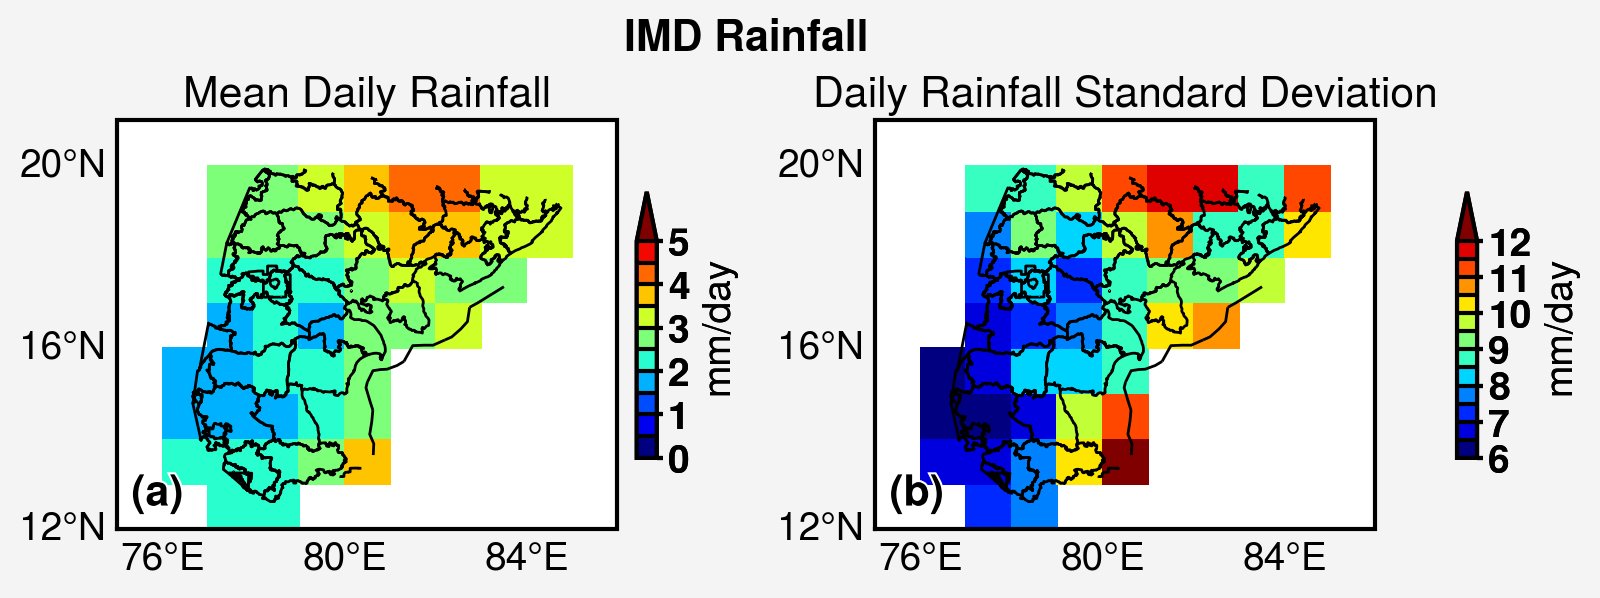

In [8]:
# Generate the figure and axis with nrows and ncols for subplots ###
##### proj = 'cyl' is the Cylindrical Equidistant Map projection used by Cartopy ###
fig, axs=plot.subplots(ncols=2,nrows=1, proj='cyl',tight=True) 

lat_min = 12 # # Minimum latitude on the map
lat_max = 21 # Maximum latitude on the map
lon_min = 75 # # Minimum longitude on the map
lon_max = 86 # # Maximum longitude on the map

cm = 'jet' # Colormap 'rainbow' , 'viridis', 'RdYlBu', 'RdBu' etc..
ex= 'max' # Color bar arrow ,'min', 'max', 'none','both'

#Now, we can format all the axes at once using these commands

axs.format(lonlim=(lon_min, lon_max), 
           latlim=(lat_min, lat_max), 
           labels=True,
           innerborders=False, 
           latlines=4, lonlines=4,
           abc='(a)', abcloc='ll', 
           gridminor=False,
           suptitle='IMD Rainfall' )

######## Limits as above; ### labels = True for lat lon labels,
###### inner borders = False , If True, it will show rivers #####
###latlines=1, lonlines=1  spacing ########
#abc=False, It abc='(a)', it will automatically give subplot (a),(b),(c) etc....
####abcloc='ll', abc location
#### gridminor=False; if true it will show all gridlines of lat , lon

# Subtitles for each plot
# We can declare the subtitles now and use it further
title=['Mean Daily Rainfall','Daily Rainfall Standard Deviation' ]
vars =['ds_clip','ds_clip_std']
levels_mean= np.arange(0,5.5,0.5)  # generates a sequence of numbers from 0 to 6 with  a spacing of 0.5
levels_std= np.arange(6,12.5,0.5)
levels=['levels_mean','levels_std']



###########Subplots ################ 

#contourf for contours

#pcolormesh for psuedo color plot

#Each subplot axis is numbered as axs[0] or axs[1] etc....]

# We can loop over each plot by indexing it as axs[i] where i is the indexing variable

for i in range(0,2): 
        #######################
        
        m=axs[i].pcolor(globals()[vars[i]], # globals() and vars[i] are used to index and generate the variable name
        cmap=cm, # Colormap
        transform=ccrs.PlateCarree(), # cartopy map projection
        extend=ex,  #colorbar style
        levels = globals()[levels[i]],
        )
        axs[i].add_geometries(Reader(fname).geometries(),
                      ccrs.PlateCarree(),facecolor='None',edgecolor='black', 
                      linewidth=1) # overlaying the shapefile
        axs[i].format(title=title[i])
        axs[i].colorbar(m,loc='r',drawedges=True, width = 0.10 , length=0.65, label='mm/day') 


#fig.colorbar will ive 1 common colorbar for all plots. But for common colorbar give explict levels.

#Use axs[0].colorbar for individual colorbars ######## 

# axs[1].colorbar(n,loc='b',drawedges=True, width = 0.10 , length=0.65, label= 'Rainfall')


In [9]:
# Saving the figures
# Use the desired file extesnsion (jpg, eps, png, svg etc.)
fig.savefig('/home/carbform/Climate_Data_Plotting/plots/2.svg')